In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from lib.utils import *

plt.rcParams['font.family'] = 'Times New Roman'

# LST evaluation

In [ ]:
df_all = []

'''
Notice:
We cannot provide in-situ data from the 6 pyrgeometer sites due to the data policy.
Please contact the respective PIs for access.
'''
df_eco_6sites = pd.read_csv('data/site/eco_6sites_c1.csv')
df_eco_6sites = df_eco_6sites.query('qc=="0b00" | qc=="0b01"')
df_eco_6sites.rename(columns={'LST_station': 'lst_site'}, inplace=True)
df_all.append(df_eco_6sites)

df_eco_flux = pd.read_csv('data/site/eco_flux.csv') # nighttime clear-sky matchups (qa = 0b00 or 0b01)
df_all.append(df_eco_flux)

for df in df_all:
    df.reset_index(drop=True, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

    L2 = df['rad2'].values
    L4 = df['rad4'].values
    L5 = df['rad5'].values
    vza = df['vza'].values
    tpw = df['pwv'].values * 10 # cm to mm

    lst_dl, emi_dl, qa_dl = DL_SW_TES(L2, L4, L5, vza, tpw=tpw) # None
    month = df['Date'].dt.month.values
    lat = df['lat'].values
    lst_zheng, emi_zheng, qa_zheng = SW_TES(L2, L4, L5, lat, month)
    
    lst_wang, emi_wang, qa_wang = SWDTES(L2, L4, L5, tpw, t1=0.05)

    df['lst_dl'] = lst_dl
    df['qa_dl'] = qa_dl
    df['lst_zheng'] = lst_zheng
    df['qa_zheng'] = qa_zheng
    df['lst_wang'] = lst_wang
    df['qa_wang'] = qa_wang

100%|██████████| 536/536 [00:00<00:00, 4571.68it/s]


In [5]:
def extract_data(df):
    sites = df['ID'].unique()

    # results without sw-tes like methods
    lst_eco_0, lst_dl_0, lst_site_0 = [], [], []
    num_before, num_after = [], []
    # results with sw-tes like methods
    lst_eco_1, lst_dl_1, lst_zheng_1, lst_wang_1, lst_site_1, tpw_1 = [], [], [], [], [], []

    for site in sites:
        df_i =  df[df['ID'] == site]
        lst_eco, lst_site = df_i['lst'].values, df_i['lst_site'].values
        lst_dl, qa_dl = df_i['lst_dl'].values, df_i['qa_dl'].values
        tpw = df_i['pwv'].values

        # without sw-tes
        idx_valid = (qa_dl==1)
        lst_eco_0i, lst_dl_0i, lst_site_0i = lst_eco[idx_valid], lst_dl[idx_valid], lst_site[idx_valid]
        num_before.append(len(lst_eco_0i))
        idx_final1 = outlier_removal(lst_site_0i-lst_eco_0i)
        idx_final2 = outlier_removal(lst_site_0i-lst_dl_0i)
        idx_final = np.intersect1d(idx_final1, idx_final2)
        lst_eco_0i, lst_dl_0i, lst_site_0i = lst_eco_0i[idx_final], lst_dl_0i[idx_final], lst_site_0i[idx_final]
        num_after.append(len(lst_eco_0i))

        # with sw-tes
        lst_zheng, qa_zheng = df_i['lst_zheng'].values, df_i['qa_zheng'].values
        lst_wang, qa_wang = df_i['lst_wang'].values, df_i['qa_wang'].values
        idx_valid = (qa_dl==1) & (qa_zheng==1) & (qa_wang==1)
        lst_site_1i, lst_eco_1i = lst_site[idx_valid], lst_eco[idx_valid]
        lst_dl_1i, lst_zheng_1i, lst_wang_1i = lst_dl[idx_valid], lst_zheng[idx_valid], lst_wang[idx_valid]
        idx_final1 = outlier_removal(lst_site_1i-lst_eco_1i)
        idx_final2 = outlier_removal(lst_site_1i-lst_dl_1i)
        idx_final3 = outlier_removal(lst_site_1i-lst_zheng_1i)
        idx_final4 = outlier_removal(lst_site_1i-lst_wang_1i)
        idx_final = np.intersect1d(np.intersect1d(np.intersect1d(idx_final1, idx_final2), idx_final3), idx_final4)
        lst_site_1i, lst_eco_1i = lst_site_1i[idx_final], lst_eco_1i[idx_final]
        lst_dl_1i, lst_zheng_1i, lst_wang_1i = lst_dl_1i[idx_final], lst_zheng_1i[idx_final], lst_wang_1i[idx_final]
        tpw_1i = tpw[idx_valid][idx_final]

        lst_eco_0.append(lst_eco_0i)
        lst_dl_0.append(lst_dl_0i)
        lst_site_0.append(lst_site_0i)
        lst_eco_1.append(lst_eco_1i)
        lst_dl_1.append(lst_dl_1i)
        lst_zheng_1.append(lst_zheng_1i)
        lst_wang_1.append(lst_wang_1i)
        lst_site_1.append(lst_site_1i)
        tpw_1.append(tpw_1i)

    return sites, lst_eco_0, lst_dl_0, lst_site_0, lst_eco_1, lst_dl_1, lst_zheng_1, lst_wang_1, lst_site_1, tpw_1, num_before, num_after

sites_high, lst_eco_0_6sites, lst_dl_0_6sites, lst_site_0_6sites, lst_eco_1_6sites, \
    lst_dl_1_6sites, lst_zheng_1_6sites, lst_wang_1_6sites, lst_site_1_6sites, tpw_1_6sites, num_before_6sites, num_after_6sites = extract_data(df_eco_6sites)
sites_flux, lst_eco_0_flux, lst_dl_0_flux, lst_site_0_flux, lst_eco_1_flux, lst_dl_1_flux, \
    lst_zheng_1_flux, lst_wang_1_flux, lst_site_1_flux, tpw_1_flux, num_before_flux, num_after_flux = extract_data(df_eco_flux)

## compare DL-SW-TES and TES

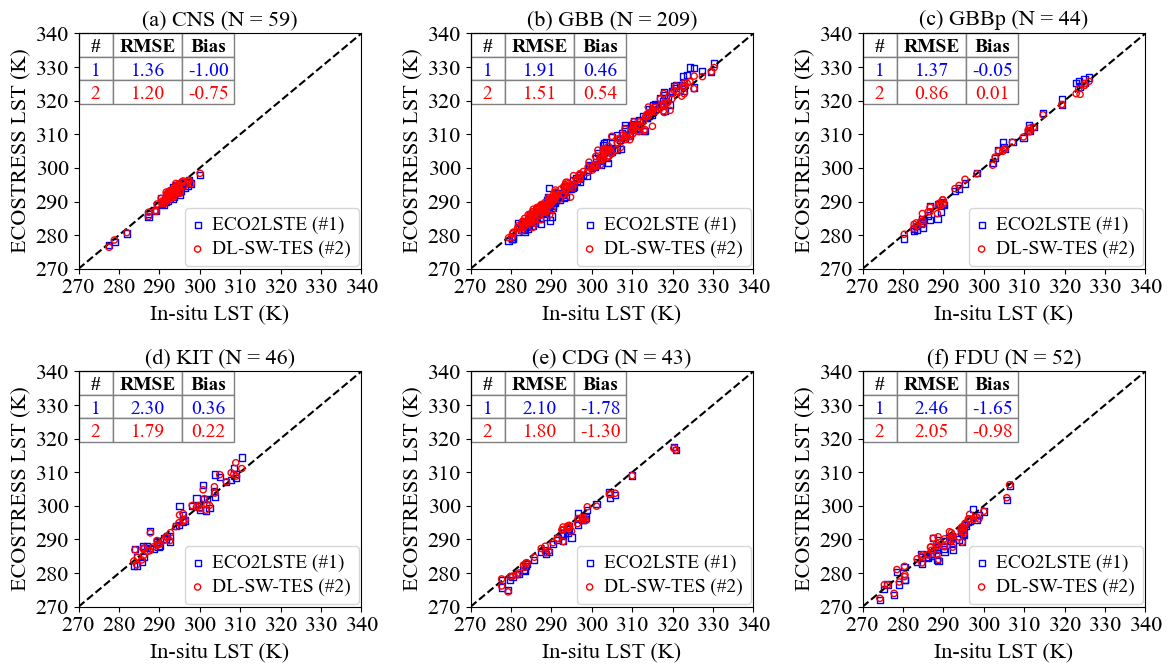

In [6]:
# 6 high-quality sites
plt.rcParams['font.size'] = 16
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

vmin, vmax = 270, 340
for i, site in enumerate(sites_high):
    lst_site_i, lst_eco_i, lst_dl_i = lst_site_0_6sites[i], lst_eco_0_6sites[i], lst_dl_0_6sites[i]
    rmse_eco = root_mean_squared_error(lst_site_i, lst_eco_i)
    bias_eco = np.mean(lst_eco_i-lst_site_i)
    rmse_dl = root_mean_squared_error(lst_site_i, lst_dl_i)
    bias_dl = np.mean(lst_dl_i-lst_site_i)

    axi = axs[i//3, i%3]
    axi.scatter(lst_site_i, lst_eco_i, color='none', marker='s', edgecolor='b', s=20, zorder=1, label='ECO2LSTE (#1)')
    axi.scatter(lst_site_i, lst_dl_i, color='none', marker='o', edgecolor='r', s=20, zorder=3, label='DL-SW-TES (#2)')
    axi.plot([vmin, vmax], [vmin, vmax], 'k--')
    axi.set_xlim(vmin, vmax)
    axi.set_ylim(vmin, vmax)
    axi.set_xticks(np.arange(vmin, vmax+1, 10))
    axi.set_yticks(np.arange(vmin, vmax+1, 10))
    axi.set_xlabel('In-situ LST (K)')
    axi.set_ylabel('ECOSTRESS LST (K)')

    axi.legend(loc='lower right', handlelength=0.5, handletextpad=0.5, labelspacing=0.3,
               fontsize=14, bbox_to_anchor=(1.025, -0.03))
    axi.set_title(f'({chr(97+i)}) {sites_high[i]} (N = {len(lst_site_i)})', fontsize=16)

     # insert table of accuracy metrics
    data = [
    ['#', 'RMSE', 'Bias'],
    ["1", f"{rmse_eco:.2f}", f"{bias_eco:.2f}"],
    ["2", f"{rmse_dl:.2f}", f"{bias_dl:.2f}"]
    ]
    table = axi.table(cellText=data, cellLoc='center', colWidths=[0.2, 0.4, 0.3], bbox=[0.0, 0.7, 0.55, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor("gray")
        table_text = cell.get_text()
        table_text.set_horizontalalignment('center')
        table_text.set_verticalalignment('center_baseline')
        table_text.set_weight('bold') if row == 0 else None
        table_text.set_color('b') if row == 1 else None
        table_text.set_color('r') if row == 2 else None

fig.tight_layout()
# fig.savefig('figs/site_evaluation_rad_2methods.tif', dpi=300, bbox_inches='tight')

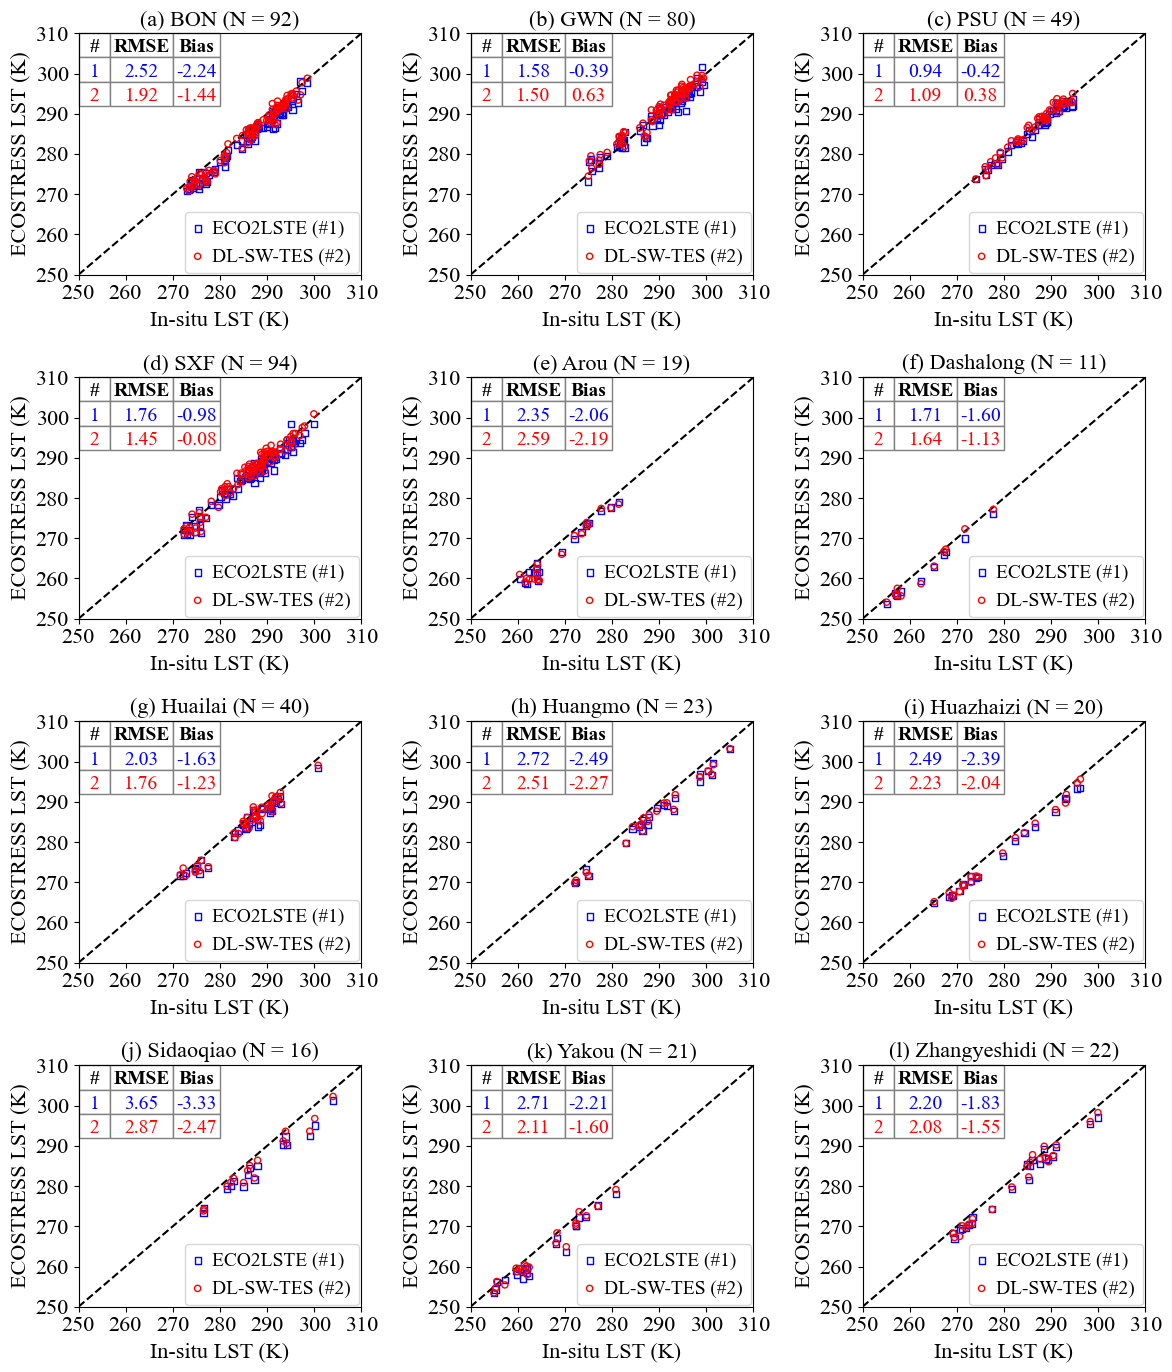

In [7]:
# 12 flux sites
plt.rcParams['font.size'] = 16
fig, axs = plt.subplots(4, 3, figsize=(12, 14))
vmin, vmax = 250, 310

for i, site in enumerate(sites_flux):
    lst_site_i, lst_eco_i, lst_dl_i = lst_site_0_flux[i], lst_eco_0_flux[i], lst_dl_0_flux[i]
    rmse_eco = root_mean_squared_error(lst_site_i, lst_eco_i)
    bias_eco = np.mean(lst_eco_i-lst_site_i)
    rmse_dl = root_mean_squared_error(lst_site_i, lst_dl_i)
    bias_dl = np.mean(lst_dl_i-lst_site_i)

    axi = axs[i//3, i%3]
    axi.scatter(lst_site_i, lst_eco_i, color='none', marker='s', edgecolor='b', s=20, zorder=1, label='ECO2LSTE (#1)')
    axi.scatter(lst_site_i, lst_dl_i, color='none', marker='o', edgecolor='r', s=20, zorder=3, label='DL-SW-TES (#2)')
    axi.plot([vmin, vmax], [vmin, vmax], 'k--')
    axi.set_xlim(vmin, vmax)
    axi.set_ylim(vmin, vmax)
    axi.set_xticks(np.arange(vmin, vmax+1, 10))
    axi.set_yticks(np.arange(vmin, vmax+1, 10))
    axi.set_xlabel('In-situ LST (K)')
    axi.set_ylabel('ECOSTRESS LST (K)')

    axi.legend(loc='lower right', handlelength=0.5, handletextpad=0.5, fontsize=14, bbox_to_anchor=(1.025, -0.035))
    axi.set_title(f'({chr(97+i)}) {sites_flux[i]} (N = {len(lst_site_i)})', fontsize=16)

    # insert table of accuracy metrics
    data = [
    ['#', 'RMSE', 'Bias'],
    ["1", f"{rmse_eco:.2f}", f"{bias_eco:.2f}"],
    ["2", f"{rmse_dl:.2f}", f"{bias_dl:.2f}"]
    ]
    table = axi.table(cellText=data, cellLoc='center', colWidths=[0.2, 0.4, 0.3], bbox=[0.0, 0.7, 0.5, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor("gray")
        table_text = cell.get_text()
        table_text.set_horizontalalignment('center')
        table_text.set_verticalalignment('center_baseline')
        table_text.set_weight('bold') if row == 0 else None
        table_text.set_color('b') if row == 1 else None
        table_text.set_color('r') if row == 2 else None

fig.tight_layout()
# fig.savefig('figs/site_evaluation_flux_2methods.tif', dpi=300, bbox_inches='tight')

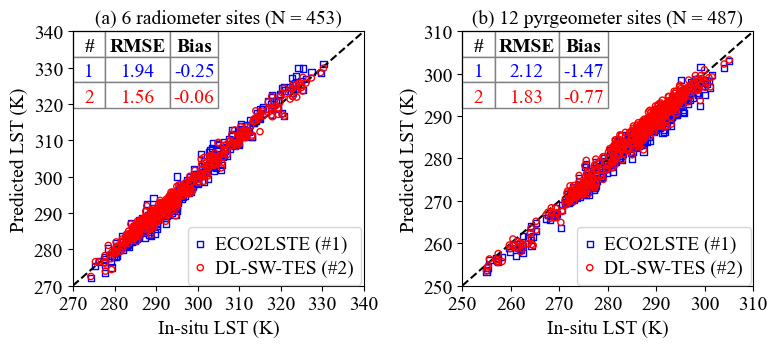

In [8]:
plt.rcParams['font.size'] = 14
fig, axs = plt.subplots(1, 2, figsize=(8, 3.7))

lst_eco_6sites_array = np.concatenate(lst_eco_0_6sites)
lst_dl_6sites_array = np.concatenate(lst_dl_0_6sites)
lst_site_6sites_array = np.concatenate(lst_site_0_6sites)
lst_eco_flux_array = np.concatenate(lst_eco_0_flux)
lst_dl_flux_array = np.concatenate(lst_dl_0_flux)
lst_site_flux_array = np.concatenate(lst_site_0_flux)

lst_site_all = [lst_site_6sites_array, lst_site_flux_array]
lst_eco_all = [lst_eco_6sites_array, lst_eco_flux_array]
lst_dl_all = [lst_dl_6sites_array, lst_dl_flux_array]

titles = ['6 radiometer sites', '12 pyrgeometer sites']

for i in range(2):
    lst_site_i = lst_site_all[i]
    lst_eco_i = lst_eco_all[i]
    lst_dl_i = lst_dl_all[i]

    # calculate accuracy metrics
    rmse_eco, bias_eco = root_mean_squared_error(lst_site_i, lst_eco_i), np.mean(lst_eco_i-lst_site_i)
    rmse_dl, bias_dl = root_mean_squared_error(lst_site_i, lst_dl_i), np.mean(lst_dl_i-lst_site_i)

    ax = axs[i]
    ax.scatter(lst_site_i, lst_eco_i, color='none', marker='s', edgecolor='b', s=20, zorder=1, label='ECO2LSTE (#1)')
    ax.scatter(lst_site_i, lst_dl_i, color='none', marker='o', edgecolor='r', s=20, zorder=3, label='DL-SW-TES (#2)')
    
    if i == 0:
        ax.plot([270, 340], [270, 340], 'k--')
        ax.set_xlim(270, 340)
        ax.set_ylim(270, 340)
        ax.set_xticks(np.arange(270, 340+1, 10))
        ax.set_yticks(np.arange(270, 340+1, 10))
    else:
        ax.plot([250, 310], [250, 310], 'k--')
        ax.set_xlim(250, 310)
        ax.set_ylim(250, 310)
        ax.set_xticks(np.arange(250, 310+1, 10))
        ax.set_yticks(np.arange(250, 310+1, 10))

    ax.set_xlabel('In-situ LST (K)')
    ax.set_ylabel('Predicted LST (K)')
    ax.legend(loc='lower right', handlelength=0.5, handletextpad=0.5, labelspacing=0.3,
              bbox_to_anchor=(1.025, -0.035))
    ax.set_title(f'({chr(97+i)}) {titles[i]} (N = {len(lst_site_i)})', fontsize=14)

    data = [
    ['#', 'RMSE', 'Bias'],
    ["1", f"{rmse_eco:.2f}", f"{bias_eco:.2f}"],
    ["2", f"{rmse_dl:.2f}", f"{bias_dl:.2f}"]
    ]
    table = ax.table(cellText=data, cellLoc='center', colWidths=[0.2, 0.4, 0.3], bbox=[0.0, 0.7, 0.5, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor("gray")
        table_text = cell.get_text()
        table_text.set_horizontalalignment('center')
        table_text.set_verticalalignment('center_baseline')
        table_text.set_weight('bold') if row == 0 else None
        table_text.set_color('b') if row == 1 else None
        table_text.set_color('r') if row == 2 else None

fig.tight_layout()
# fig.savefig('figs/site_evaluation_all_2methods.tif', dpi=300, bbox_inches='tight')

## compare all four algorithms

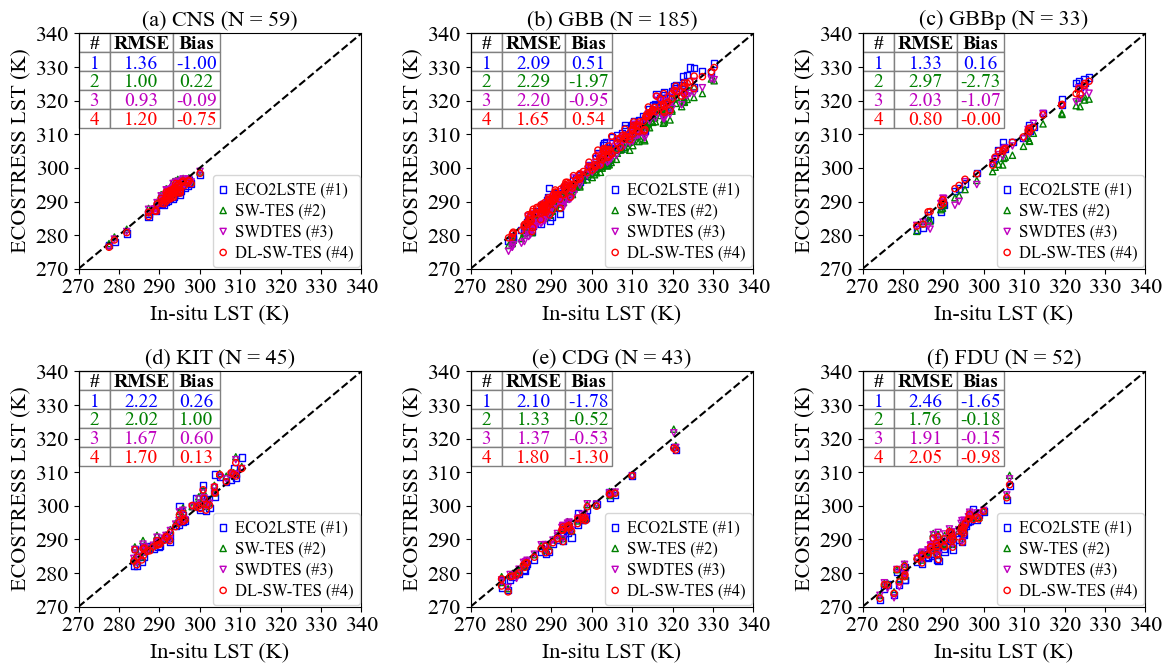

In [9]:
# 6 high-quality sites
plt.rcParams['font.size'] = 16
fig, axs = plt.subplots(2, 3, figsize=(12, 7)) # 11, 6.5

vmin, vmax = 270, 340
for i, site in enumerate(sites_high):
    lst_site_i, lst_eco_i, lst_dl_i = lst_site_1_6sites[i], lst_eco_1_6sites[i], lst_dl_1_6sites[i]
    lst_zheng_i, lst_wang_i = lst_zheng_1_6sites[i], lst_wang_1_6sites[i]
    rmse_eco = root_mean_squared_error(lst_site_i, lst_eco_i)
    bias_eco = np.mean(lst_eco_i-lst_site_i)
    rmse_dl = root_mean_squared_error(lst_site_i, lst_dl_i)
    bias_dl = np.mean(lst_dl_i-lst_site_i)
    rmse_zheng = root_mean_squared_error(lst_site_i, lst_zheng_i)
    bias_zheng = np.mean(lst_zheng_i-lst_site_i)
    rmse_wang = root_mean_squared_error(lst_site_i, lst_wang_i)
    bias_wang = np.mean(lst_wang_i-lst_site_i)

    axi = axs[i//3, i%3]
    axi.scatter(lst_site_i, lst_eco_i, color='none', marker='s', edgecolor='b', s=20, zorder=1, label='ECO2LSTE (#1)')
    axi.scatter(lst_site_i, lst_zheng_i, color='none', marker='^', edgecolor='g', s=20, zorder=2, label='SW-TES (#2)')
    axi.scatter(lst_site_i, lst_wang_i, color='none', marker='v', edgecolor='m', s=20, zorder=2, label='SWDTES (#3)')
    axi.scatter(lst_site_i, lst_dl_i, color='none', marker='o', edgecolor='r', s=20, zorder=3, label='DL-SW-TES (#4)')
    axi.plot([vmin, vmax], [vmin, vmax], 'k--')
    axi.set_xlim(vmin, vmax)
    axi.set_ylim(vmin, vmax)
    axi.set_xticks(np.arange(vmin, vmax+1, 10))
    axi.set_yticks(np.arange(vmin, vmax+1, 10))
    axi.set_xlabel('In-situ LST (K)')
    axi.set_ylabel('ECOSTRESS LST (K)')

    axi.legend(loc='lower right', handlelength=0.4, handletextpad=0.5, labelspacing=0.3,
                     fontsize=12, bbox_to_anchor=(1.025, -0.03))
    axi.set_title(f'({chr(97+i)}) {sites_high[i]} (N = {len(lst_site_i)})', fontsize=16)

    # insert table of accuracy metrics
    data = [
    ['#', 'RMSE', 'Bias'],
    ["1", f"{rmse_eco:.2f}", f"{bias_eco:.2f}"],
    ["2", f"{rmse_zheng:.2f}", f"{bias_zheng:.2f}"],
    ["3", f"{rmse_wang:.2f}", f"{bias_wang:.2f}"],
    ["4", f"{rmse_dl:.2f}", f"{bias_dl:.2f}"]
    ]
    table = axi.table(cellText=data, cellLoc='center', colWidths=[0.2, 0.4, 0.3], bbox=[0.0, 0.6, 0.5, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor("gray")
        table_text = cell.get_text()
        table_text.set_horizontalalignment('center')
        table_text.set_verticalalignment('center_baseline')
        table_text.set_weight('bold') if row == 0 else None
        table_text.set_color('b') if row == 1 else None
        table_text.set_color('g') if row == 2 else None
        table_text.set_color('m') if row == 3 else None
        table_text.set_color('r') if row == 4 else None
        
fig.tight_layout()
# fig.savefig('figs/site_evaluation_rad_4methods.tif', dpi=300, bbox_inches='tight')

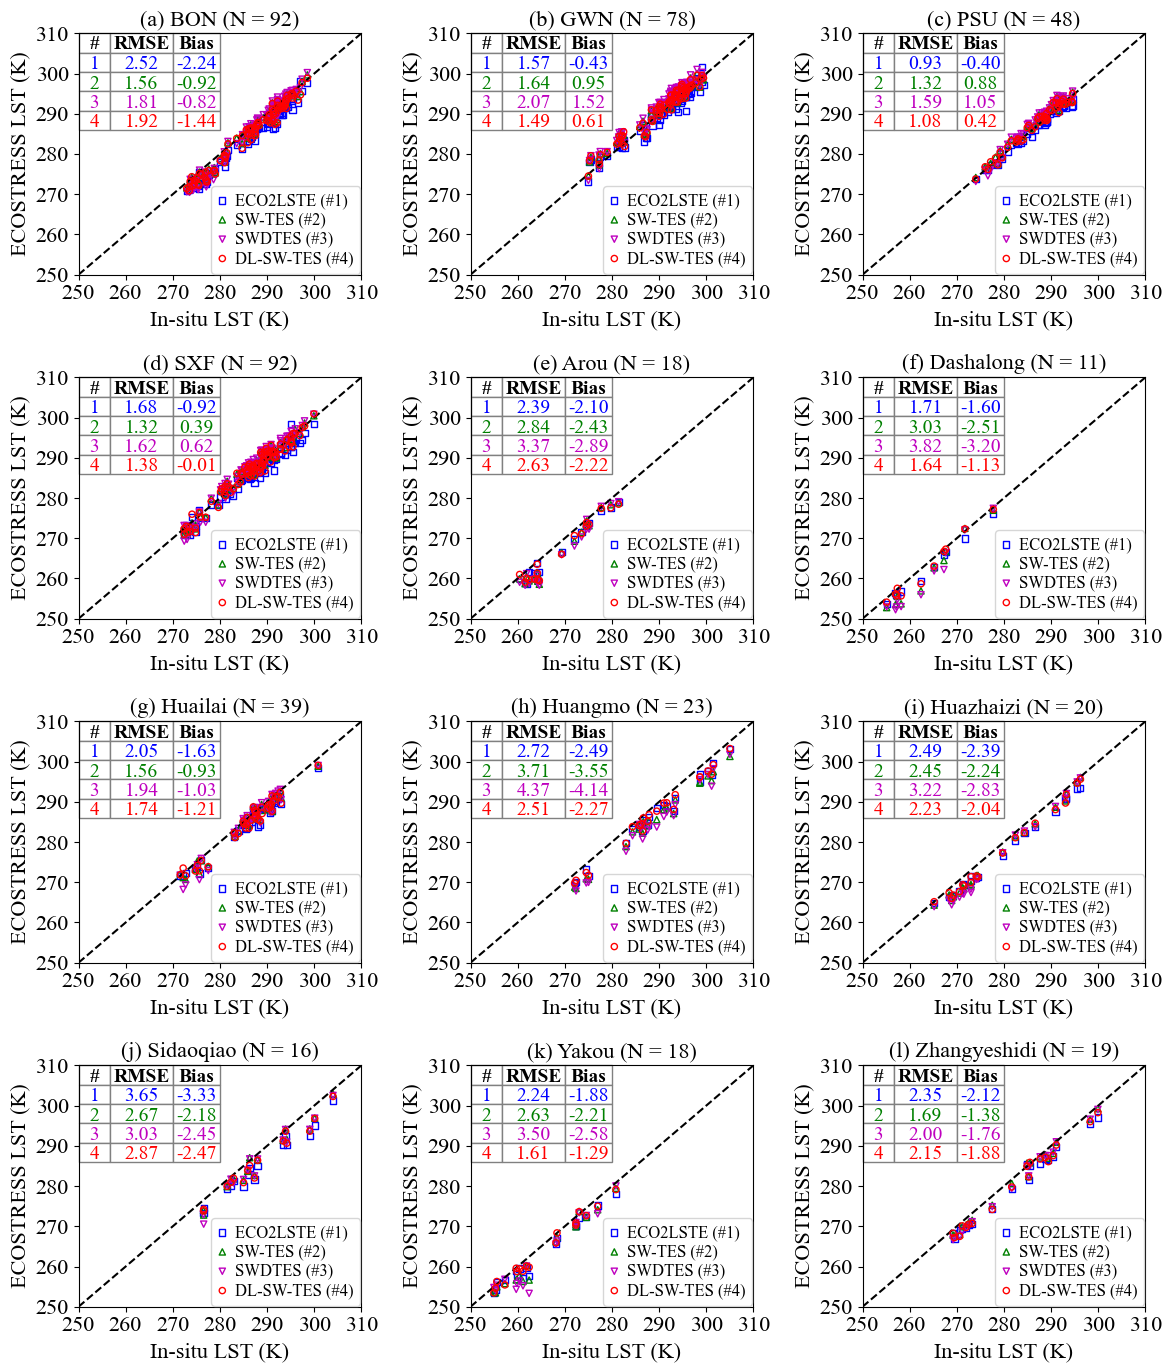

In [10]:
# 12 flux sites
plt.rcParams['font.size'] = 16
fig, axs = plt.subplots(4, 3, figsize=(12, 14))
vmin, vmax = 250, 310

for i, site in enumerate(sites_flux):
    lst_site_i, lst_eco_i, lst_dl_i = lst_site_1_flux[i], lst_eco_1_flux[i], lst_dl_1_flux[i]
    lst_zheng_i, lst_wang_i = lst_zheng_1_flux[i], lst_wang_1_flux[i]
    rmse_eco = root_mean_squared_error(lst_site_i, lst_eco_i)
    bias_eco = np.mean(lst_eco_i-lst_site_i)
    rmse_dl = root_mean_squared_error(lst_site_i, lst_dl_i)
    bias_dl = np.mean(lst_dl_i-lst_site_i)
    rmse_zheng = root_mean_squared_error(lst_site_i, lst_zheng_i)
    bias_zheng = np.mean(lst_zheng_i-lst_site_i)
    rmse_wang = root_mean_squared_error(lst_site_i, lst_wang_i)
    bias_wang = np.mean(lst_wang_i-lst_site_i)

    axi = axs[i//3, i%3]
    axi.scatter(lst_site_i, lst_eco_i, color='none', marker='s', edgecolor='b', s=20, zorder=1, label='ECO2LSTE (#1)')
    axi.scatter(lst_site_i, lst_zheng_i, color='none', marker='^', edgecolor='g', s=20, zorder=2, label='SW-TES (#2)')
    axi.scatter(lst_site_i, lst_wang_i, color='none', marker='v', edgecolor='m', s=20, zorder=2, label='SWDTES (#3)')
    axi.scatter(lst_site_i, lst_dl_i, color='none', marker='o', edgecolor='r', s=20, zorder=3, label='DL-SW-TES (#4)')
    axi.plot([vmin, vmax], [vmin, vmax], 'k--')
    axi.set_xlim(vmin, vmax)
    axi.set_ylim(vmin, vmax)
    axi.set_xticks(np.arange(vmin, vmax+1, 10))
    axi.set_yticks(np.arange(vmin, vmax+1, 10))
    axi.set_xlabel('In-situ LST (K)')
    axi.set_ylabel('ECOSTRESS LST (K)')

    axi.legend(loc='lower right', handlelength=0.5, handletextpad=0.5, labelspacing=0.2,
               fontsize=12, bbox_to_anchor=(1.025, -0.03))
    axi.set_title(f'({chr(97+i)}) {sites_flux[i]} (N = {len(lst_site_i)})', fontsize=16)

    data = [
    ['#', 'RMSE', 'Bias'],
    ["1", f"{rmse_eco:.2f}", f"{bias_eco:.2f}"],
    ["2", f"{rmse_zheng:.2f}", f"{bias_zheng:.2f}"],
    ["3", f"{rmse_wang:.2f}", f"{bias_wang:.2f}"],
    ["4", f"{rmse_dl:.2f}", f"{bias_dl:.2f}"]
    ]
    table = axi.table(cellText=data, cellLoc='center', colWidths=[0.2, 0.4, 0.3], bbox=[0.0, 0.6, 0.5, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor("gray")
        table_text = cell.get_text()
        table_text.set_horizontalalignment('center')
        table_text.set_verticalalignment('center_baseline')
        table_text.set_weight('bold') if row == 0 else None
        table_text.set_color('b') if row == 1 else None
        table_text.set_color('g') if row == 2 else None
        table_text.set_color('m') if row == 3 else None
        table_text.set_color('r') if row == 4 else None

fig.tight_layout()
# fig.savefig('figs/site_evaluation_flux_4methods.tif', dpi=300, bbox_inches='tight')

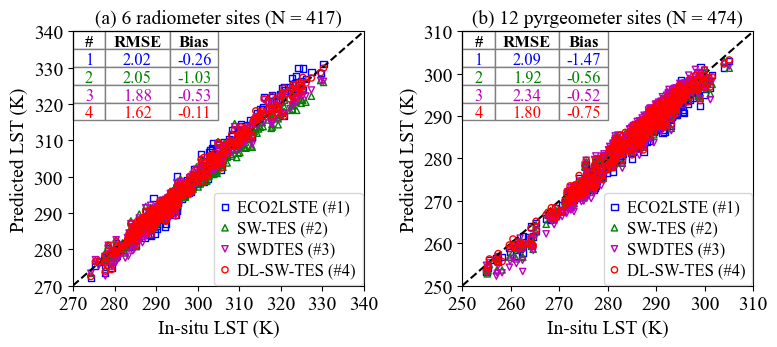

In [11]:
plt.rcParams['font.size'] = 14
fig, axs = plt.subplots(1, 2, figsize=(8, 3.7))

lst_eco_6sites_array = np.concatenate(lst_eco_1_6sites)
lst_dl_6sites_array = np.concatenate(lst_dl_1_6sites)
lst_zheng_6sites_array = np.concatenate(lst_zheng_1_6sites)
lst_wang_6sites_array = np.concatenate(lst_wang_1_6sites)
lst_site_6sites_array = np.concatenate(lst_site_1_6sites)

lst_eco_flux_array = np.concatenate(lst_eco_1_flux)
lst_dl_flux_array = np.concatenate(lst_dl_1_flux)
lst_zheng_flux_array = np.concatenate(lst_zheng_1_flux)
lst_wang_flux_array = np.concatenate(lst_wang_1_flux)
lst_site_flux_array = np.concatenate(lst_site_1_flux)

lst_site_all = [lst_site_6sites_array, lst_site_flux_array]
lst_eco_all = [lst_eco_6sites_array, lst_eco_flux_array]
lst_dl_all = [lst_dl_6sites_array, lst_dl_flux_array]
lst_zheng_all = [lst_zheng_6sites_array, lst_zheng_flux_array]
lst_wang_all = [lst_wang_6sites_array, lst_wang_flux_array]

titles = ['6 radiometer sites', '12 pyrgeometer sites']

for i in range(2):
    lst_site_i = lst_site_all[i]
    lst_eco_i = lst_eco_all[i]
    lst_dl_i = lst_dl_all[i]
    lst_zheng_i = lst_zheng_all[i]
    lst_wang_i = lst_wang_all[i]

    # calculate accuracy metrics
    rmse_eco, bias_eco = root_mean_squared_error(lst_site_i, lst_eco_i), np.mean(lst_eco_i-lst_site_i)
    rmse_dl, bias_dl = root_mean_squared_error(lst_site_i, lst_dl_i), np.mean(lst_dl_i-lst_site_i)
    rmse_zheng, bias_zheng = root_mean_squared_error(lst_site_i, lst_zheng_i), np.mean(lst_zheng_i-lst_site_i)
    rmse_wang, bias_wang = root_mean_squared_error(lst_site_i, lst_wang_i), np.mean(lst_wang_i-lst_site_i)

    ax = axs[i]
    ax.scatter(lst_site_i, lst_eco_i, color='none', marker='s', edgecolor='b', s=20, zorder=1, label='ECO2LSTE (#1)')
    ax.scatter(lst_site_i, lst_zheng_i, color='none', marker='^', edgecolor='g', s=20, zorder=2, label='SW-TES (#2)')
    ax.scatter(lst_site_i, lst_wang_i, color='none', marker='v', edgecolor='m', s=20, zorder=2, label='SWDTES (#3)')
    ax.scatter(lst_site_i, lst_dl_i, color='none', marker='o', edgecolor='r', s=20, zorder=3, label='DL-SW-TES (#4)')
    
    if i == 0:
        ax.plot([270, 340], [270, 340], 'k--')
        ax.set_xlim(270, 340)
        ax.set_ylim(270, 340)
        ax.set_xticks(np.arange(270, 340+1, 10))
        ax.set_yticks(np.arange(270, 340+1, 10))
    else:
        ax.plot([250, 310], [250, 310], 'k--')
        ax.set_xlim(250, 310)
        ax.set_ylim(250, 310)
        ax.set_xticks(np.arange(250, 310+1, 10))
        ax.set_yticks(np.arange(250, 310+1, 10))

    ax.set_xlabel('In-situ LST (K)')
    ax.set_ylabel('Predicted LST (K)')
    ax.legend(loc='lower right', handlelength=0.5, handletextpad=0.5, labelspacing=0.3,
                    fontsize=12, bbox_to_anchor=(1.025, -0.03))
    ax.set_title(f'({chr(97+i)}) {titles[i]} (N = {len(lst_site_i)})', fontsize=14)

    data = [
    ['#', 'RMSE', 'Bias'],
    ["1", f"{rmse_eco:.2f}", f"{bias_eco:.2f}"],
    ["2", f"{rmse_zheng:.2f}", f"{bias_zheng:.2f}"],
    ["3", f"{rmse_wang:.2f}", f"{bias_wang:.2f}"],
    ["4", f"{rmse_dl:.2f}", f"{bias_dl:.2f}"]
    ]
    table = ax.table(cellText=data, cellLoc='center', colWidths=[0.2, 0.4, 0.3], bbox=[0.0, 0.65, 0.5, 0.35])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor("gray")
        table_text = cell.get_text()
        table_text.set_horizontalalignment('center')
        table_text.set_verticalalignment('center_baseline')
        table_text.set_weight('bold') if row == 0 else None
        table_text.set_color('b') if row == 1 else None
        table_text.set_color('g') if row == 2 else None
        table_text.set_color('m') if row == 3 else None
        table_text.set_color('r') if row == 4 else None

fig.tight_layout()
# fig.savefig('figs/site_evaluation_all_4methods.tif', dpi=300, bbox_inches='tight')

In [10]:
tpw_6sites = np.concatenate(tpw_1_6sites)
idx_tpw = (tpw_6sites>3)
rmse_eco_tpw, bias_eco_tpw = root_mean_squared_error(lst_site_6sites_array[idx_tpw], lst_eco_6sites_array[idx_tpw]), np.mean(lst_eco_6sites_array[idx_tpw]-lst_site_6sites_array[idx_tpw])
rmse_dl_tpw, bias_dl_tpw = root_mean_squared_error(lst_site_6sites_array[idx_tpw], lst_dl_6sites_array[idx_tpw]), np.mean(lst_dl_6sites_array[idx_tpw]-lst_site_6sites_array[idx_tpw])
rmse_zheng_tpw, bias_zheng_tpw = root_mean_squared_error(lst_site_6sites_array[idx_tpw], lst_zheng_6sites_array[idx_tpw]), np.mean(lst_zheng_6sites_array[idx_tpw]-lst_site_6sites_array[idx_tpw])
rmse_wang_tpw, bias_wang_tpw = root_mean_squared_error(lst_site_6sites_array[idx_tpw], lst_wang_6sites_array[idx_tpw]), np.mean(lst_wang_6sites_array[idx_tpw]-lst_site_6sites_array[idx_tpw])

idx_lst = (lst_site_6sites_array>320)
rmse_eco_lst, bias_eco_lst = root_mean_squared_error(lst_site_6sites_array[idx_lst], lst_eco_6sites_array[idx_lst]), np.mean(lst_eco_6sites_array[idx_lst]-lst_site_6sites_array[idx_lst])
rmse_dl_lst, bias_dl_lst = root_mean_squared_error(lst_site_6sites_array[idx_lst], lst_dl_6sites_array[idx_lst]), np.mean(lst_dl_6sites_array[idx_lst]-lst_site_6sites_array[idx_lst])
rmse_zheng_lst, bias_zheng_lst = root_mean_squared_error(lst_site_6sites_array[idx_lst], lst_zheng_6sites_array[idx_lst]), np.mean(lst_zheng_6sites_array[idx_lst]-lst_site_6sites_array[idx_lst])
rmse_wang_lst, bias_wang_lst = root_mean_squared_error(lst_site_6sites_array[idx_lst], lst_wang_6sites_array[idx_lst]), np.mean(lst_wang_6sites_array[idx_lst]-lst_site_6sites_array[idx_lst])

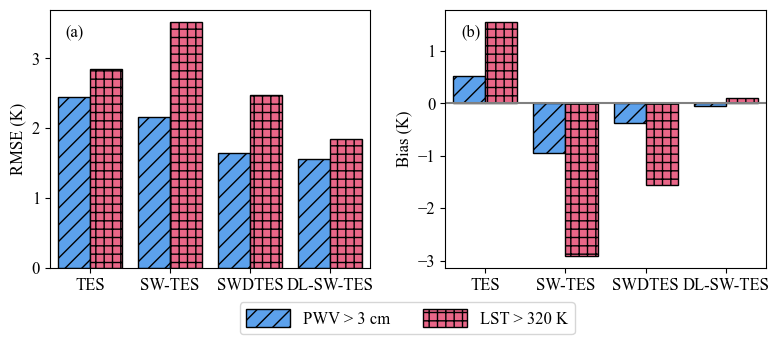

In [11]:
plt.rcParams['font.size'] = 12
fig, axs = plt.subplots(1, 2, figsize=(8, 3.2))

wd = 0.4
bars_rmse_tpw = axs[0].bar([1-wd/2,2-wd/2,3-wd/2,4-wd/2], [rmse_eco_tpw, rmse_zheng_tpw, rmse_wang_tpw, rmse_dl_tpw], color='#5CA1EC', edgecolor='k', width=wd)
bars_rmse_lst = axs[0].bar([1+wd/2,2+wd/2,3+wd/2,4+wd/2], [rmse_eco_lst, rmse_zheng_lst, rmse_wang_lst, rmse_dl_lst], color='#E96688', edgecolor='k', width=wd)

for bar1, bar2 in zip(bars_rmse_tpw, bars_rmse_lst):
    bar1.set_hatch('//')
    bar2.set_hatch('++')

axs[0].set_ylabel('RMSE (K)')
axs[0].set_xticks([1,2,3,4])
axs[0].set_xticklabels(['TES', 'SW-TES', 'SWDTES', 'DL-SW-TES'])
axs[0].text(0.05, 0.9, '(a)', transform=axs[0].transAxes)
axs[0].set_xlim(0.5, 4.5)

bars_rmse_tpw = axs[1].bar([1-wd/2,2-wd/2,3-wd/2,4-wd/2], [bias_eco_tpw, bias_zheng_tpw, bias_wang_tpw, bias_dl_tpw], color='#5CA1EC', edgecolor='k', width=wd, label='PWV > 3 cm')
bars_rmse_lst = axs[1].bar([1+wd/2,2+wd/2,3+wd/2,4+wd/2], [bias_eco_lst, bias_zheng_lst, bias_wang_lst, bias_dl_lst], color='#E96688', edgecolor='k', width=wd, label='LST > 320 K')

for bar1, bar2 in zip(bars_rmse_tpw, bars_rmse_lst):
    bar1.set_hatch('//')
    bar2.set_hatch('++')

axs[1].hlines(0, 0.5, 4.5, 'gray', linestyles='-')
axs[1].set_ylabel('Bias (K)')
axs[1].set_xticks([1,2,3,4])
axs[1].set_xticklabels(['TES', 'SW-TES', 'SWDTES','DL-SW-TES'])
axs[1].text(0.05, 0.9, '(b)', transform=axs[1].transAxes)
axs[1].set_xlim(0.5, 4.5)

fig.tight_layout()

axs[1].legend(loc='upper right', handlelength=2.6, handleheight=1.25, bbox_to_anchor=(0.43, -0.1), ncol=2)
# fig.savefig('figs/site_evaluation_extreme.tif', dpi=300, bbox_inches='tight')